In [122]:
import numpy as np
import torch

In [123]:
class NeuralNetwork(torch.nn.Module):

    def __init__(self, n_inputs: int, n_layers: int, n_neurons: int, n_output: int, act):
        super().__init__()

        self.n_inputs = n_inputs 
        self.n_layers = n_layers
        self.n_neurons = n_neurons

        layers = []

        layers.append( torch.nn.Linear(n_inputs, n_neurons))
        for i in range(n_layers): layers.extend( [torch.nn.Linear(n_neurons,n_neurons), act])
        layers.append(torch.nn.Linear(n_neurons, n_output))

        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()    

## Equação do Calor

A equação do calor é dada através da seguinte equação diferencial:

$$
\dfrac{\partial u}{\partial t} = \alpha \dfrac{\partial^2 u}{\partial x^2}, \hspace{1cm}  x\in [0,1],t\in [0,1]
$$

onde $\alpha = 0.4$, $u(0,t) = u(1,t) = 0$ e $u(x,0) = \sin(\dfrac{n \pi x}{L}), 0 < x < L$ e $n = 1,2,3,\ldots$.

Teremos que $L = 1$, como a largura da barra e $n=1$ a frequencia senoidal da condição inicial.

A solução exata é dada por $u(x,t) = e^{\frac{-n^2 \pi^2 \alpha t}{L^2}} \sin(\dfrac{n \pi x}{L})$

In [124]:
#PARAMETROS DA EQUAÇÃO
alpha = 0.4
L = 1
n = 1

#DECLARAÇÃO DA EQUAÇÃO DIFERENCIAL
def pde(x, t, model):
    input = torch.stack((x,t),1)

    u = model(input)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    return u_t - alpha * u_xx

#DECLARAÇÃO DO DOMÍNIO
x_dom = (0,1)
t_dom = (0,1)
batch_size = 1000

#DECLARAÇÃO DAS CONDIÇÕES DE CONTORNO E PONTOS INTERNOS
x = torch.FloatTensor(batch_size).uniform_(x_dom[0], x_dom[1]).requires_grad_()
t = torch.FloatTensor(batch_size).uniform_(t_dom[0], t_dom[1]).requires_grad_()
ic_x = torch.tensor([0.0,1.0])
ic_t = torch.tensor([0.0])

#PREPARAÇÃO DOS DADOS DE TREINAMENTO
input_ic1 = torch.cartesian_prod(ic_x, t)
input_ic2 = torch.cartesian_prod(x, ic_t)
ic_t_target = torch.sin((n * torch.pi * x))

#DECLARAÇÃO DA ARQUITETURA USADA
model = NeuralNetwork(2, 1, 20, 1, torch.nn.Tanh()) # 1 input, 1 camada oculta, 20 neurônios/cam. oculta, 1 output, activação: Tanh

#PARAMETROS DO TREINAMENTO
learning_rate = 1e-3
epochs = 5000
optmizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
loss_fn = torch.nn.MSELoss()

In [125]:
#TREINAMENTO
for ep in range(epochs):

    optmizer.zero_grad()

    #CALCULO DO CUSTO PARA A CONDIÇÃO DE CONTORNO
    out_icx = model(input_ic1)
    ic_x_target = torch.zeros_like(out_icx)
    l1 = loss_fn(out_icx, ic_x_target)

    out_ict = model(input_ic2)
    l2 = loss_fn(out_ict, ic_t_target)
    
    #CALCULO DO CUSTO PARA A EDP
    out_pde = pde(x, t, model)
    pde_target = torch.zeros_like(out_pde)
    l3 = loss_fn(out_pde, pde_target)
    
    #BACKPROPAGATION
    loss = l1 + l2 + l3
    loss.backward(retain_graph=True)
    optmizer.step()

    with torch.autograd.no_grad():
        print(f'Epochs: {ep}/{epochs} Loss: {loss.item()}')

Epochs: 0/5000 Loss: 0.5295163989067078
Epochs: 1/5000 Loss: 0.4958617091178894
Epochs: 2/5000 Loss: 0.4654838442802429
Epochs: 3/5000 Loss: 0.4383304715156555
Epochs: 4/5000 Loss: 0.41434478759765625
Epochs: 5/5000 Loss: 0.3934498429298401
Epochs: 6/5000 Loss: 0.37553539872169495
Epochs: 7/5000 Loss: 0.36044979095458984
Epochs: 8/5000 Loss: 0.347994863986969
Epochs: 9/5000 Loss: 0.33792269229888916
Epochs: 10/5000 Loss: 0.3299390971660614
Epochs: 11/5000 Loss: 0.32371410727500916
Epochs: 12/5000 Loss: 0.31889772415161133
Epochs: 13/5000 Loss: 0.31513869762420654
Epochs: 14/5000 Loss: 0.31210431456565857
Epochs: 15/5000 Loss: 0.30949893593788147
Epochs: 16/5000 Loss: 0.3070785403251648
Epochs: 17/5000 Loss: 0.30466005206108093
Epochs: 18/5000 Loss: 0.3021239936351776
Epochs: 19/5000 Loss: 0.29941126704216003
Epochs: 20/5000 Loss: 0.29651564359664917
Epochs: 21/5000 Loss: 0.29347285628318787
Epochs: 22/5000 Loss: 0.2903483808040619
Epochs: 23/5000 Loss: 0.28722530603408813
Epochs: 24/50

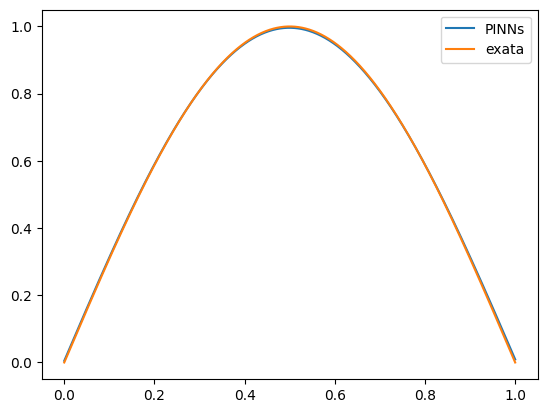

In [126]:
import matplotlib.pyplot as plt 

size = 1000
x_test = torch.linspace(x_dom[0], x_dom[1], size)
t_test = torch.tensor([0.0])
input = torch.cartesian_prod(x_test, t_test)
out = model(input)

def exata(x, t): return torch.exp(-(n**2 * torch.pi**2 * alpha * t[:])/ L**2 ) * torch.sin((n*torch.pi * x[:])/L)
out_exata = exata(x_test, t_test)

x_test = x_test.detach().numpy()
out = out.detach().numpy()
out_exata = out_exata.detach().numpy()

#PLOTAGEM
plt.plot(x_test, out, label = 'PINNs')
plt.plot(x_test, out_exata, label = 'exata')
plt.legend()
plt.show()